Importing the required libraries.

In [ ]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import os, glob
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from random import sample

Creating the required dataframes.

In [ ]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")
tags = pd.read_csv("tags.csv")
links = pd.read_csv("links.csv")
print(movies.head())
print(ratings.head())
print(tags.head())
print(links.head())

   movieId  ...                                       genres
0        1  ...  Adventure|Animation|Children|Comedy|Fantasy
1        2  ...                   Adventure|Children|Fantasy
2        3  ...                               Comedy|Romance
3        4  ...                         Comedy|Drama|Romance
4        5  ...                                       Comedy

[5 rows x 3 columns]
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
4       2    89774              MMA  1445715200
   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  

# Q1 Exploratory Data Analysis

**1. Nan values per column**

In [ ]:
links.isnull().sum(axis = 0)

movieId    0
imdbId     0
tmdbId     8
dtype: int64

In [ ]:
movies.isnull().sum(axis = 0)

movieId    0
title      0
genres     0
dtype: int64

In [ ]:
tags.isnull().sum(axis = 0)

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

In [ ]:

ratings.isnull().sum(axis = 0)

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

There were no Nan values in the dataset except links.csv and ratings.csv. Total nan values found is 8+1 = 9.

**2. Frequently occuring values**

* Most Rating values given

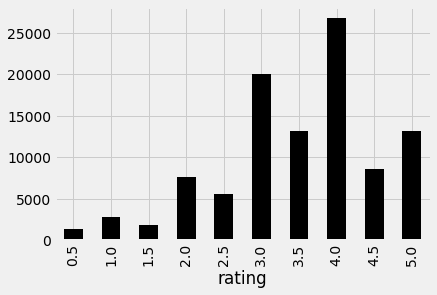

In [ ]:
ratings.groupby('rating').size().plot(kind='bar',color="black");

Clearly we can see that most of the movies have got ratings 3.0 and 4.0 whereas very few users have rated movies in lower ranges. 

* Top frequently used tags

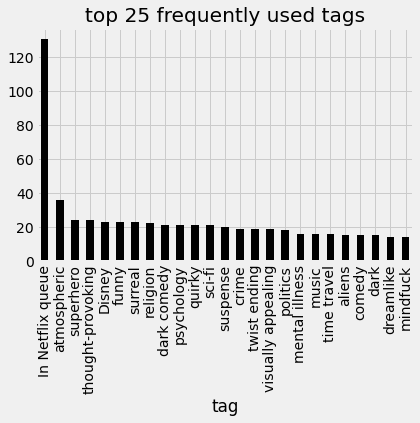

In [ ]:
tags.groupby('tag').size().nlargest(25).plot(kind='bar',title="top 25 frequently used tags", color="black");

* Least frequently used tags

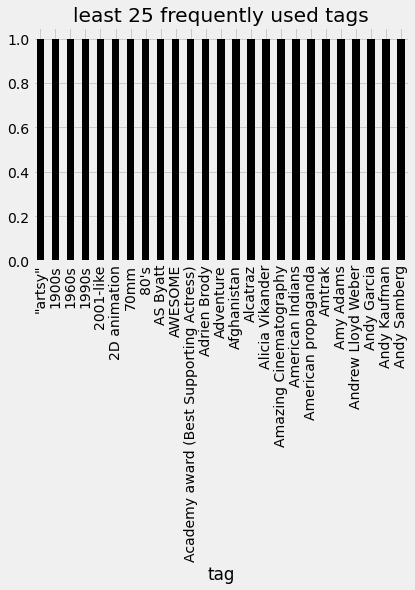

In [ ]:
tags.groupby('tag').size().nsmallest(25).plot(kind='bar',title="least 25 frequently used tags",color="black");

'In Netflix queue' was the most used tag used more than 120 number of times whereas the least used tags are used not more than a single time.

* Top 25 most reviewed movie

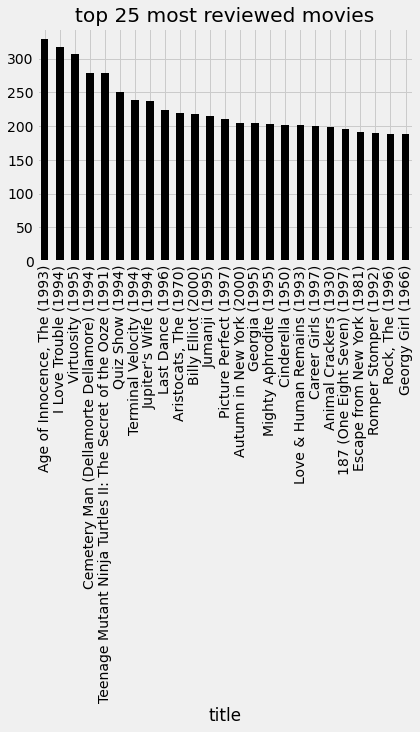

In [ ]:
ratings.join(movies['title'], on='movieId').groupby('title').size().nlargest(25).plot(kind='bar',title="top 25 most reviewed movies", color="black");

* Bottom 25 least reviewed movies

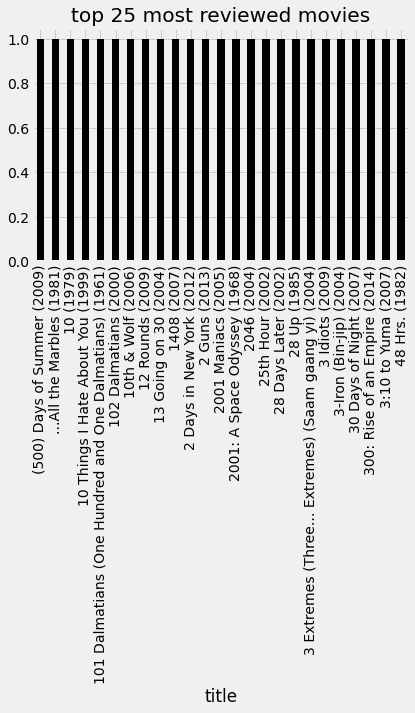

In [ ]:
ratings.join(movies['title'], on='movieId').groupby('title').size().nsmallest(25).plot(kind='bar',title="top 25 most reviewed movies",color="black");

From the plots above we can infer that the movie 'The Age of Innocence (1993)' has been reviewed by most of the users. The least reviewed movies have been reviewed by not more than one user.

3. Correlations

* Links

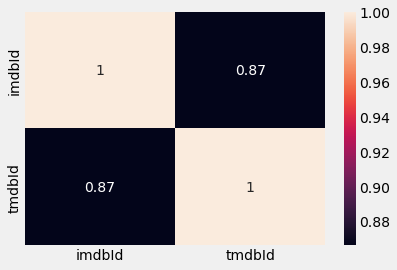

In [ ]:
links = links.drop(labels='movieId', axis=1)
corr = links.corr()
sns.heatmap(corr, annot=True)
plt.show()

There is a high correlation between the ids of movies in the 2 databases. This shows that the movies were entered into the databases at similar time and both used a similar indexing algorithm for new entries of movies.

* Ratings

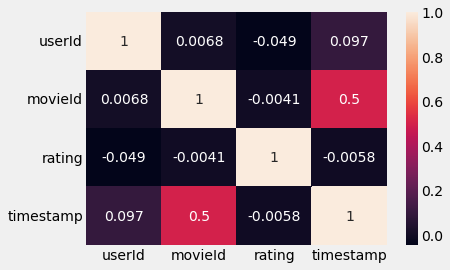

In [ ]:
corr = ratings.corr()
sns.heatmap(corr, annot=True)
plt.show()

There is no such relation found from the above plot.

4.  Miscellaneous

* Mean rating of 50 movies

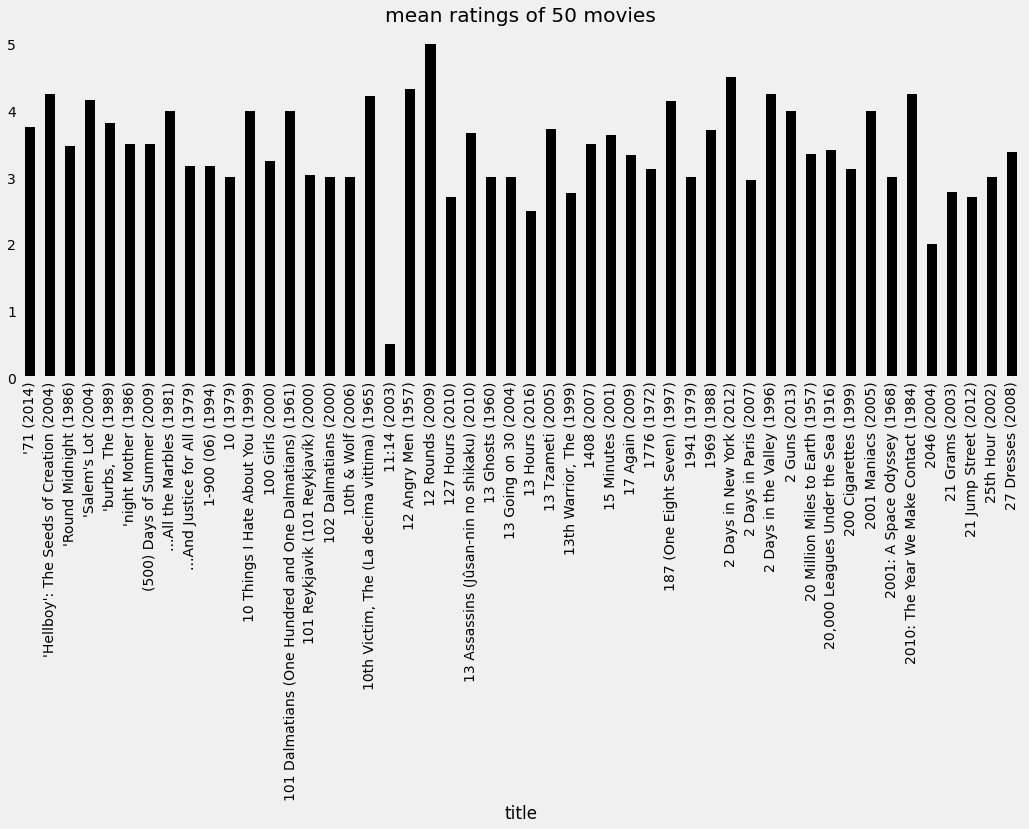

In [ ]:
movie_means = ratings.join(movies['title'], on='movieId').groupby('title').rating.mean()
movie_means[:50].plot(kind='bar', grid=False, figsize=(16,6), title="mean ratings of 50 movies",color="black");

* Top and Bottom 30 movies (rating wise)

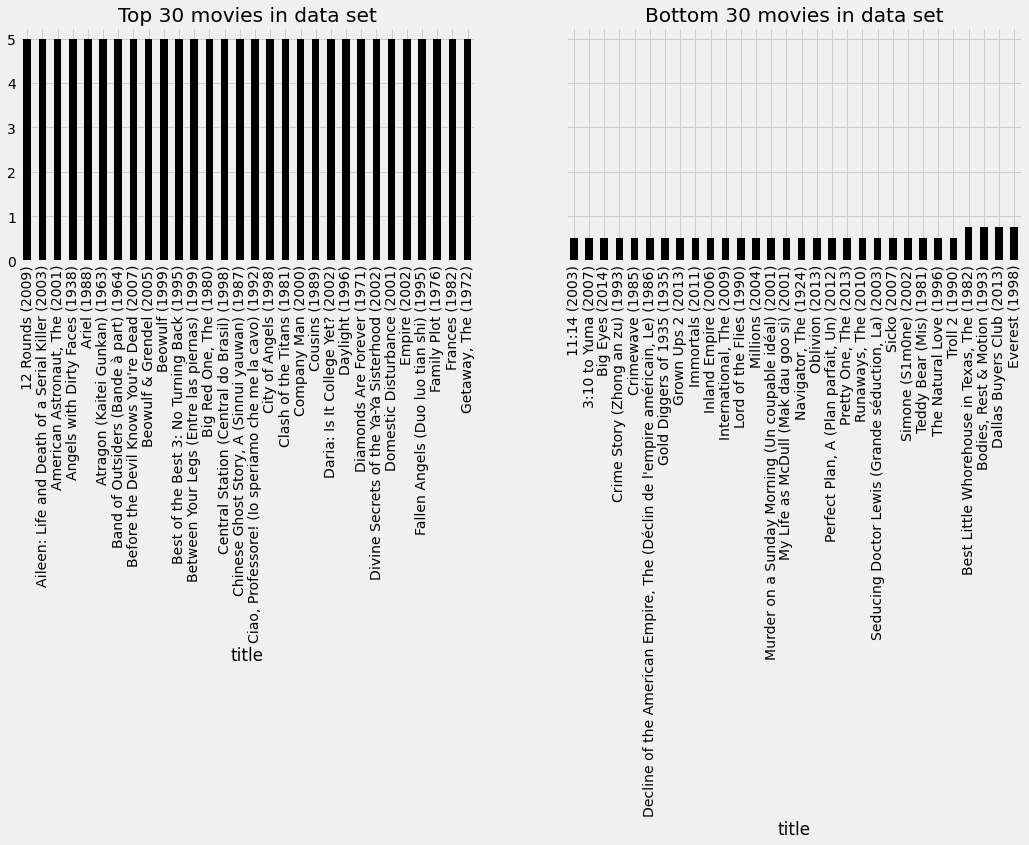

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,4), sharey=True)
movie_means.nlargest(30).plot(kind='bar', ax=ax1, title="Top 30 movies in data set",color="black");
movie_means.nsmallest(30).plot(kind='bar', ax=ax2, title="Bottom 30 movies in data set",color="black");

* Rating 

In [ ]:
import plotly.express as px
fig = px.scatter_matrix(ratings)
fig.show()

- A certain trend that we can see is the number of movies rated exponentially increased with time which is an indication of more movies being produced and user actively rating the movies with time.
- Also we can notice that rating system of jumps of 0.5 came later. Initially, it had jumps of *1*

* Mean rating for different tags

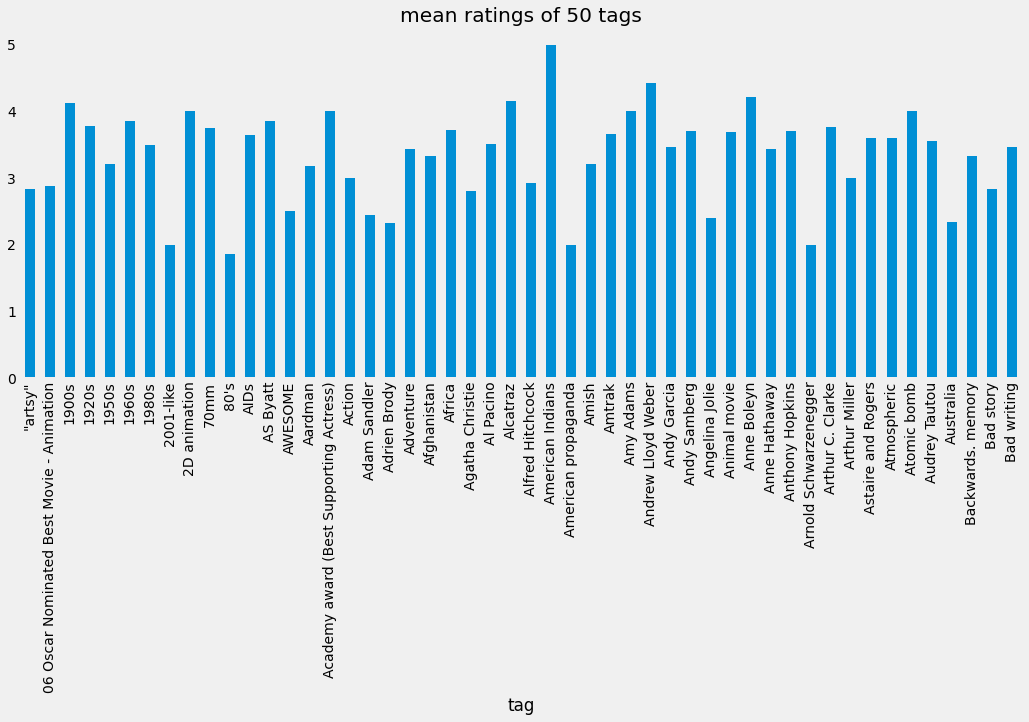

In [ ]:
# ratings.join(movies['title'], on='movieId').groupby('title').rating.mean()
rating_tags = ratings.join(tags['tag'], on='movieId').groupby('tag').rating.mean()
rating_tags[:50].plot(kind='bar', grid=False, figsize=(16,6), title="mean ratings of 50 tags");

* Top and bottom 30 rated movies with given tag

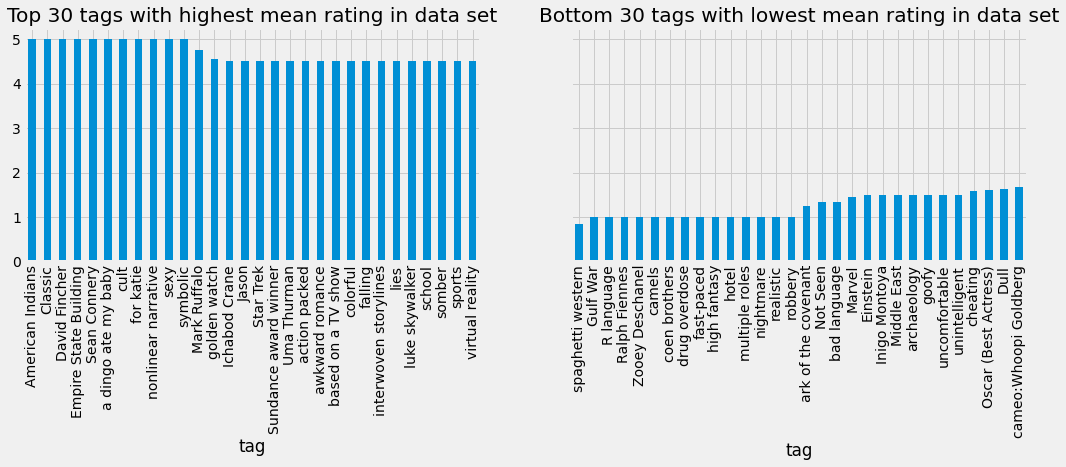

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,4), sharey=True)
rating_tags.nlargest(30).plot(kind='bar', ax=ax1, title="Top 30 tags with highest mean rating in data set");
rating_tags.nsmallest(30).plot(kind='bar', ax=ax2, title="Bottom 30 tags with lowest mean rating in data set");

People loved movies that showed classical stuff, American natives and buildings.

Whereas there was not so much love shown for eastern flavour to the movies. Movies based on  robbery, cheating, war were not liked a lot

* Movies vs Time ( hue: rating)

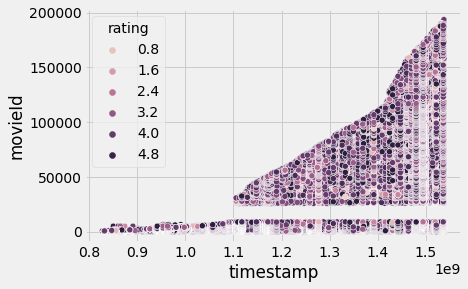

In [ ]:
sns.scatterplot(data=ratings, x="timestamp", y="movieId", hue="rating")

* Mean ratings at different time

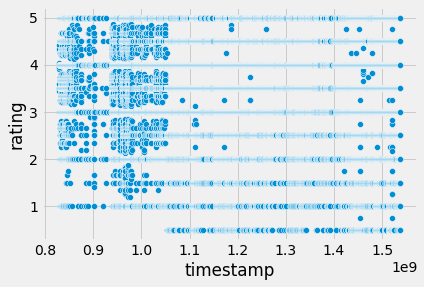

In [ ]:
sns.scatterplot(data=ratings[['timestamp','rating',]].groupby('timestamp').mean(), x="timestamp", y="rating")

* Trends of Rating of Genre of Movies (dark comedy vs funny)

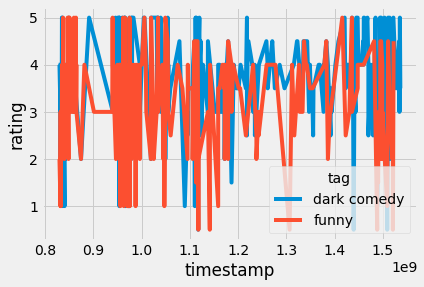

In [ ]:
ratings_by_tags = ratings.join(tags['tag'], on='movieId')
ratings_by_tags = ratings_by_tags[ratings_by_tags['tag'].isin(['dark comedy','funny'])]
ratings_by_tags

sns.lineplot(data=ratings_by_tags, x="timestamp", y="rating", hue = "tag")


People have liked dark comedy more than funny movies.

* Number of votes by users for each movieId

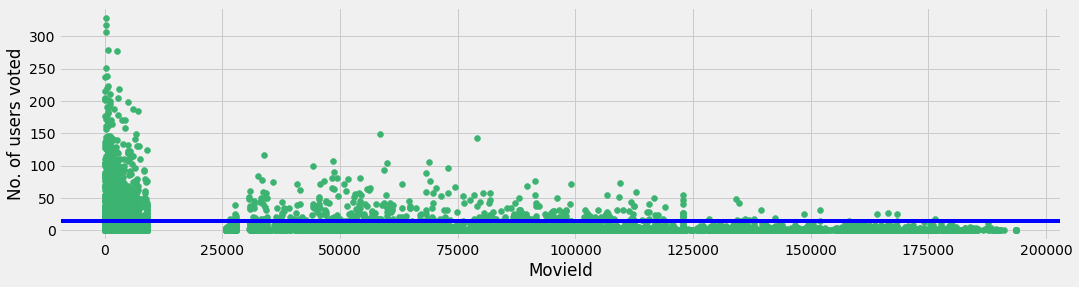

In [ ]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')
f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=15,color='b')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

# Q2 Recommendation System

Creating a dictionary to store the movie titles corresponding to movie id.

In [ ]:
id = []
movie = []
for index,row in movies.iterrows():
  id.append(row['movieId'])
  movie.append(row['title'])

Expanding the dataframe to make interpretations easier.

The columns represents the movie ids a particular user has rated.

In [ ]:
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset.head()

userId   1    2    3    4    5    6    7    ...  604  605  606  607  608  609  610
movieId                                     ...                                   
1        4.0  NaN  NaN  NaN  4.0  NaN  4.5  ...  3.0  4.0  2.5  4.0  2.5  3.0  5.0
2        NaN  NaN  NaN  NaN  NaN  4.0  NaN  ...  5.0  3.5  NaN  NaN  2.0  NaN  NaN
3        4.0  NaN  NaN  NaN  NaN  5.0  NaN  ...  NaN  NaN  NaN  NaN  2.0  NaN  NaN
4        NaN  NaN  NaN  NaN  NaN  3.0  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN
5        NaN  NaN  NaN  NaN  NaN  5.0  NaN  ...  3.0  NaN  NaN  NaN  NaN  NaN  NaN

[5 rows x 610 columns]

Replacing the NaN with 0.

In [ ]:
final_dataset.fillna(0,inplace=True)
final_dataset.head()

userId   1    2    3    4    5    6    7    ...  604  605  606  607  608  609  610
movieId                                     ...                                   
1        4.0  0.0  0.0  0.0  4.0  0.0  4.5  ...  3.0  4.0  2.5  4.0  2.5  3.0  5.0
2        0.0  0.0  0.0  0.0  0.0  4.0  0.0  ...  5.0  3.5  0.0  0.0  2.0  0.0  0.0
3        4.0  0.0  0.0  0.0  0.0  5.0  0.0  ...  0.0  0.0  0.0  0.0  2.0  0.0  0.0
4        0.0  0.0  0.0  0.0  0.0  3.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5        0.0  0.0  0.0  0.0  0.0  5.0  0.0  ...  3.0  0.0  0.0  0.0  0.0  0.0  0.0

[5 rows x 610 columns]

The transaction corresponding to a user is the list of the movie ids that the user has rated. In the above dataframe we assume that if a movie is rated 3 or below should be attributed to 0 because subjectively that movie should not be recommended. The movies with rating more than 3 are considered worth recommending. Hence the function below works accordingly.

In [ ]:
def encode_units(x):
    if x<=2.5:
        return 0
    if x>2.5:
        return 1

In [ ]:
df_for_ar = final_dataset.T.applymap(encode_units)

In [ ]:
df_for_ar.head()

movieId  1       2       3       4       ...  193583  193585  193587  193609
userId                                   ...                                
1             1       0       1       0  ...       0       0       0       0
2             0       0       0       0  ...       0       0       0       0
3             0       0       0       0  ...       0       0       0       0
4             0       0       0       0  ...       0       0       0       0
5             1       0       0       0  ...       0       0       0       0

[5 rows x 9724 columns]

Importing libraries to apply association rule mining.

In [ ]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import itertools
frequent_itemsets = apriori(df_for_ar, min_support=0.075, use_colnames=True)
frequent_itemsets

support                                           itemsets
0       0.326230                                                (1)
1       0.145902                                                (2)
2       0.162295                                                (6)
3       0.193443                                               (10)
4       0.098361                                               (11)
...          ...                                                ...
229897  0.075410  (5952, 4993, 260, 356, 296, 2571, 1196, 7153, ...
229898  0.078689  (5952, 4993, 260, 356, 296, 2571, 1196, 2959, ...
229899  0.075410  (5952, 4993, 260, 356, 2571, 1196, 2959, 7153,...
229900  0.075410  (5952, 4993, 4226, 260, 356, 2571, 1196, 7153,...
229901  0.075410  (5952, 4993, 4226, 260, 356, 2571, 1196, 2959,...

[229902 rows x 2 columns]

In [ ]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules

antecedents  ... conviction
0               (1)  ...   1.148416
1               (2)  ...   1.578041
2               (1)  ...   1.141803
3               (6)  ...   1.450071
4               (1)  ...   1.138333
...             ...  ...        ...
7581525      (2571)  ...   1.124163
7581526      (1196)  ...   1.202572
7581527      (2959)  ...   1.179857
7581528      (7153)  ...   1.256865
7581529      (1210)  ...   1.226206

[7581530 rows x 9 columns]

In [ ]:
all_antecedents = [list(x) for x in rules['antecedents'].values]

Script used to recommend movies.

In [ ]:
def check(ii, ind):
  val = True
  for j in range(len(ind)):
    hello = all_antecedents[ii][j]==ind[j]
    val = val and hello
  return val

In [ ]:
def recommend(movie_list):
  indices = []
  for mov in movie_list:
    if mov in movie:
      indices.append(id[movie.index(mov)])
    else:
      continue
  # index = movie.index(mov)
  # id_ = id[index]
  indices.sort()
  desired_indices = [i for i in range(len(all_antecedents)) if len(all_antecedents[i])==len(movie_list) and check(i,indices)]
  apriori_recommendations=rules.iloc[desired_indices,].sort_values(by=['lift'],ascending=False)
  apriori_recommendations_list = [list(x) for x in apriori_recommendations['consequents'].values]
  # print(apriori_recommendations_list[0:4])
  return apriori_recommendations

# Implementation

In [ ]:
def recommend_movies(movie_list):

  answer_list = []

  # finds recommendation for the complete set of movies (containing all the elements)
  recommendations = recommend(movie_list)
  # antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction
  # if there are no recommendations rec_df is an empty dataframe
  rec_df = pd.DataFrame({"antecedents":[], "consequents":[], "antecedent support":[], "consequent support":[], "support":[], "confidence":[], "lift":[], "leverage":[], "conviction":[]})
  list_rec_df = []

  recommendations = [list(x) for x in recommendations['consequents'].values]

  # flag to tell if the recommendations of the subset have been found
  flag = False

  # the case when there is no recommendations for the complete set
  if len(recommendations)==0:

    print("case 1")

    #flag set true
    flag = True

    # find recommendations for every other subset
    dataframe = pd.DataFrame()
    for i in range(len(movie_list)):
      hello = list(itertools.combinations(movie_list, i+1))
      for tup in hello:
        movs = list(tup)
        dataframe = dataframe.append(recommend(movs))
    dataframe.sort_values(by=['lift'], ascending=False)
    # print(dataframe)
    recommendations = [list(x) for x in dataframe['consequents'].values]
    # print(recommendations)

  # list to store the ids of all the recommended movies  
  # if recommendations of all the subsets have been found then recommendations contains all those
  # else it contains the recommendations for the complete set
  num_elements = []
  for i in range(len(recommendations)):
    for j in range(len(recommendations[i])):
      if recommendations[i][j] in num_elements:
        continue
      else:
        num_elements.append(recommendations[i][j])

  # If the number of recommendations are not enough for complete set of movies
  new_df = rec_df
  if len(num_elements)<4 and len(num_elements)> 0 and flag==False:
    print("case 2")
    for i in range(len(movie_list)):
      hello = list(itertools.combinations(movie_list, i+1))
      if i+1==len(movie_list):
        continue
      for tup in hello:
        movs = list(tup)
        if i==0:
          new_df = recommend(movs)
        else:
          new_df.append(recommend(movs))
    new_df.sort_values(by=['lift'], ascending=False)

    # the recommendations get over-written
    recommendations = [list(x) for x in new_df['consequents'].values]
    for i in range(len(recommendations)):
      for j in range(len(recommendations[i])):
        if recommendations[i][j] in num_elements:
          continue
        else:
          num_elements.append(recommendations[i][j])

    # the top four values are chosen
    num_elements = num_elements[0:4]
    for i in range(len(num_elements)):
      index = id.index(num_elements[i])
      answer_list.append(movie[index])

    # if now also there are not enough recommendations we will go for random recommendation
    if len(num_elements)<4:
      print("case 3")
      remaining = 4-len(num_elements)
      for i in range(remaining):
        while 0<1:
          film = sample(id,1)
          film = film[0]
          if film in movie_list or film in num_elements:
            continue
          else:
            indexx = id.index(film)
            answer_list.append(movie[indexx])
            break
    return answer_list
  # if in any case we got no recommendations we go for random recommendations
  if len(num_elements)==0:
    print("case 4")
    moovi = movie_list[0]
    films = copy.deepcopy(movie)
    films.remove(moovi)
    hello = sample(films, 4)
    for m in hello:
      answer_list.append(m)
      print(m)
    return answer_list

  print("case 5")
  rng = min(4, len(num_elements))
  for ii in range(rng):
    index = id.index(num_elements[ii])
    answer_list.append(movie[index])
  return answer_list

In [ ]:
print(recommend_movies(['Chasing Amy (1997)','Fargo (1996)']))

case 1
case 5
['Pulp Fiction (1994)', 'Groundhog Day (1993)', 'Clockwork Orange, A (1971)', 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)']


In [ ]:
list_ = ["Raising Arizona (1987)",
"Apocalypse Now (1979)",
"Annie Hall (1977)",
"Secrets & Lies (1996)"]
ans = recommend_movies(list_)
print(ans)

case 1
here
55
case 5
['Fargo (1996)', 'Pulp Fiction (1994)', 'Full Metal Jacket (1987)', 'Reservoir Dogs (1992)']


In [ ]:
for i in list_:
  print(i in movie)
  print(movie.index(i))

True
210
True
896
True
511
True
98


In [ ]:
print(recommend_movies(['Fargo (1996)']))

case 5
['Pulp Fiction (1994)', 'Groundhog Day (1993)', 'Clockwork Orange, A (1971)', 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)', 'Taxi Driver (1976)', 'Forrest Gump (1994)', 'Star Wars: Episode IV - A New Hope (1977)', 'Goodfellas (1990)', 'Apocalypse Now (1979)', 'American Beauty (1999)', 'Reservoir Dogs (1992)', 'Usual Suspects, The (1995)', 'Princess Bride, The (1987)', 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Memento (2000)', 'Seven (a.k.a. Se7en) (1995)', 'Star Wars: Episode VI - Return of the Jedi (1983)', 'Silence of the Lambs, The (1991)', 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 'Shawshank Redemption, The (1994)', 'Terminator 2: Judgment Day (1991)', 'Matrix, The (1999)', 'Jurassic Park (1993)', "Ferris Bueller's Day Off (1986)", 'Aliens (1986)', 'Godfather, The (1972)', 'Monty Python and the Holy Grail (1975)', 'Blade Runner (1982)', '2001: A Space Odyssey (1968)', 'Godfather: Part II, The (1974)', "One Flew Over the 

# Reading and writing to tsv file

In [ ]:
df = pd.read_csv("2019026_2019051.tsv", sep='\t')
for i in range(len(df)):
  
  recommendations = df.iloc[i]['recommendation'].splitlines()
    
  if len(recommendations)>4:
    recommendations = recommendations[0:4]
    s = recommendations[0]
    for r in range(len(recommendations)-1):
      s = s+"\n"+recommendations[r+1]
      # print(s)
    df.iloc[i]['recommendation'] = s

In [ ]:
df

movies                                     recommendation
0    Jurassic Park (1993)\nFirst Kid (1996)\n101 Da...  Fugitive, The (1993)\nMrs. Doubtfire (1993)\nD...
1    Liar Liar (1997)\nAnastasia (1997)\nMurder at ...  Age of Innocence, The (1993)\nI Love Trouble (...
2    Clockwork Orange, A (1971)\nPostino, Il (1994)...  Reservoir Dogs (1992)\nBlade Runner (1982)\nAm...
3               Toy Story (1995)\n Pretty Woman (1990)  Jurassic Park (1993)\nPulp Fiction (1994)\nInd...
4    Hoop Dreams (1994)\nOne Flew Over the Cuckoo's...  Age of Innocence, The (1993)\nI Love Trouble (...
..                                                 ...                                                ...
745  Kiss Me, Guido (1997)\nChasing Amy (1997)\nSec...  Age of Innocence, The (1993)\nI Love Trouble (...
746  Toy Story (1995)\nMaltese Falcon, The (1941)\n...  Jurassic Park (1993)\nPulp Fiction (1994)\nInd...
747  Lion King, The (1994)\n Rock, The (1996)\n Net...  Matrix, The (1999)\nStar Wars: Episode V - The...
748  Ulee's Gold (1997)\n Michael Collins (1996)\n ...  Age of Innocence, The (1993)\nI Love Trouble (...
749  Lawrence of Arabia (1962)\nGodfather, The (197...  Age of Innocence, The (1993)\nI Love Trouble (...

[750 rows x 2 columns]

In [ ]:
df.to_csv("output.tsv", sep="\t")

In [ ]:
randomList = ["Age of Innocence, The (1993)", "I Love Trouble (1994)", "Virtuosity (1995)", "Cemetery Man (Dellamorte Dellamore) (1994)"]
df = pd.read_csv("X_test_multiX4.tsv", sep='\t')
output_df = {'movies':[], 'recommendation':[]}
for i in range(187):
  print("------------")
  print(i)
  the_movie_list = df.iloc[i]['movies']
  output_df['movies'].append(the_movie_list)
  the_movie_list = the_movie_list.splitlines()
  for mov in the_movie_list:
    if mov in movie:
      continue
    else:
      the_movie_list.remove(mov)
  if len(the_movie_list)==0:
    for j in range(len(randomList)-1):
      s = s+"\n"+randomList[j+1]
    output_df['recommendation'].append(s)
    continue
  ans = recommend_movies(the_movie_list)
  if len(ans)<4:
    jj=0
    while len(ans)<4:
      ans.append(randomList[jj])
      jj+=1
  s = ans[0]
  for j in range(len(ans)-1):
    s = s+"\n"+ans[j+1]
  output_df['recommendation'].append(s)
output_df = pd.DataFrame(output_df)
output_df.to_csv("output.tsv", sep="\t")

------------
0
case 1
case 5
------------
1
case 1
case 4
Kid Stays in the Picture, The (2002)
Out Cold (1989)
Doomsday (2008)
Prince of Tides, The (1991)
------------
2
case 1
case 5
------------
3
case 5
------------
4
case 1
case 5
------------
5
case 1
case 5
------------
6
case 1
case 5
------------
7
case 1
case 5
------------
8
case 5
------------
9
case 1
case 5
------------
10
case 1
case 5
------------
11
case 1
case 5
------------
12
case 5
------------
13
case 1
case 4
Freshman, The (1990)
Bamboozled (2000)
Proof (2005)
Star Trek III: The Search for Spock (1984)
------------
14
case 1
case 5
------------
15
case 1
case 4
Bridget Jones: The Edge of Reason (2004)
Winter's Bone (2010)
Firewalker (1986)
Time Out (L'emploi du temps) (2001)
------------
16
case 1
case 5
------------
17
case 1
case 5
------------
18
case 1
case 5
------------
19
case 1
case 4
Charlie Wilson's War (2007)
Foxfire (1996)
Winds of the Wasteland (1936)
Red Dawn (2012)
------------
20
case 1
case 5
----

In [ ]:
output_df.to_csv("output.tsv",index=False,sep="\t")

In [ ]:
print(output_df)

                                                movies                                     recommendation
0    Jurassic Park (1993)\nFirst Kid (1996)\n101 Da...  Fugitive, The (1993)\nMrs. Doubtfire (1993)\nD...
1    Liar Liar (1997)\nAnastasia (1997)\nMurder at ...  Kid Stays in the Picture, The (2002)\nOut Cold...
2    Clockwork Orange, A (1971)\nPostino, Il (1994)...  Reservoir Dogs (1992)\nBlade Runner (1982)\nAm...
3               Toy Story (1995)\n Pretty Woman (1990)  Jurassic Park (1993)\nPulp Fiction (1994)\nInd...
4    Hoop Dreams (1994)\nOne Flew Over the Cuckoo's...  Fargo (1996)\nGodfather, The (1972)\nMatrix, T...
..                                                 ...                                                ...
182  187 (1997)\nPeacemaker, The (1997)\nDesperate ...  Hudsucker Proxy, The (1994)\nEmpire of Dreams:...
183                    Toy Story (1995)\n Fargo (1996)  Jurassic Park (1993)\nPulp Fiction (1994)\nInd...
184  Sound of Music, The (1965)\n Manchurian C

# Q3 Visualising Maximal Frequent Itemset

In [ ]:
!pip install mlxtend --upgrade --no-deps

In [ ]:
from mlxtend.frequent_patterns import fpmax
maximum_frequent_itemset = fpmax.fpmax(df_for_ar, min_support=0.3, use_colnames=True)

Displaying the maximal frequent itemset.

In [ ]:
maximum_frequent_itemset

support    itemsets
0   0.300000      (4993)
1   0.303279       (150)
2   0.303279      (1210)
3   0.304918      (2858)
4   0.313115        (47)
5   0.313115      (1198)
6   0.322951        (50)
7   0.326230      (1196)
8   0.326230         (1)
9   0.336066       (527)
10  0.337705      (2959)
11  0.344262       (589)
12  0.354098       (480)
13  0.357377       (110)
14  0.383607       (260)
15  0.421311      (2571)
16  0.300000  (593, 356)
17  0.306557  (593, 318)
18  0.308197  (296, 593)
19  0.339344  (296, 356)
20  0.342623  (296, 318)
21  0.362295  (356, 318)

* Method

In [ ]:
from graphviz import Digraph
import graphviz

In [ ]:
def connections(li2, lattice, li1):
  for i in range(len(li1)):
    is_max = 1
    node1 = str(tuple(li1[i]))
    for j in range(len(li2)):
      if li1[i].issubset(li2[j]):
        node2 = str(tuple(li2[j]))
        is_max = 0
        lattice.edge(node1, node2)
    
    if is_max==1:
      lattice.node(node1, style='filled')


In [ ]:
# making frequent item set again for only visualisation purpose...
new_freq_itemset = apriori(df_for_ar, min_support=0.3, use_colnames=True)
new_freq_itemset

support    itemsets
0   0.326230         (1)
1   0.313115        (47)
2   0.322951        (50)
3   0.357377       (110)
4   0.303279       (150)
5   0.383607       (260)
6   0.470492       (296)
7   0.513115       (318)
8   0.516393       (356)
9   0.354098       (480)
10  0.336066       (527)
11  0.344262       (589)
12  0.431148       (593)
13  0.326230      (1196)
14  0.313115      (1198)
15  0.303279      (1210)
16  0.421311      (2571)
17  0.304918      (2858)
18  0.337705      (2959)
19  0.300000      (4993)
20  0.342623  (296, 318)
21  0.339344  (296, 356)
22  0.308197  (296, 593)
23  0.362295  (356, 318)
24  0.306557  (593, 318)
25  0.300000  (593, 356)

In [ ]:
lattice = Digraph(format='png')

In [ ]:
# visualizing
sizeL = 0
for i in range(len(new_freq_itemset)):
  itemset = new_freq_itemset.iloc[i]['itemsets']
  l = len(itemset)
  if l<=sizeL:
    continue
  elif l>sizeL:
    sizeL=l

li = [[] for i in range(sizeL+1)] # li[i] stores a list of itemsets of length i
li[0].append(frozenset())
for i in range(len(new_freq_itemset)):
  itemset = new_freq_itemset.iloc[i]['itemsets']
  li[len(itemset)].append(itemset)

  # call connect for each pair 
for i in range(sizeL):
  connections(li[i+1], lattice, li[i])
  
  # for last row fill maximal set
for i in range(len(li[-1])):
  z = str(tuple(li[-1][i]))
  lattice.node(z, style='filled')

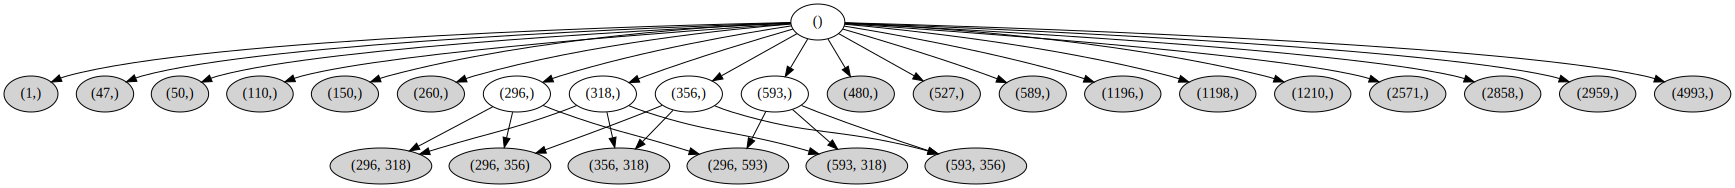

In [ ]:
lattice

In [ ]:
lattice.render()

'Digraph.gv.png'